In [1]:
# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Import dataset 
board_games = pd.read_csv("board_games_workfile2.csv", sep=';')
pd.options.display.max_columns = None
board_games.head()

,Unnamed: 0,index,game_id_base,max_players_base,max_playtime_base,min_age_base,min_players_base,min_playtime_base,year_published_base,category_base,average_rating_base,users_rated_base,average_learning_complexity_api,average_strategy_complexity_api,min_age_category_base,year_published_category_base,users_rated_log_base,game_id_base_d,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d,price_api,price_ca_api,price_uk_api,price_au_api,discount_api,listing_clicks_api
0,0,0,1,5,240,14,3,240,1986,"Economic,Negotiation,Political",7.66508,4498,0.0,0.0,13-17,1981-1990,8.411388,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
1,1,1,2,4,30,12,3,30,1981,"Card Game,Fantasy",6.60815,478,0.0,0.0,8-12,1981-1990,6.169611,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.99,0.00,0.0,0.00,0.0,0
2,2,4,3,4,60,10,2,30,1998,"Abstract Strategy,Medieval",7.44119,12019,0.0,0.0,8-12,1991-2000,9.394244,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
3,3,7,4,4,60,12,2,60,1992,Ancient,6.60675,314,0.0,0.0,8-12,1991-2000,5.749393,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0
4,4,8,5,6,90,12,3,90,1964,Economic,7.35830,15195,0.0,0.0,8-12,1961-1970,9.628722,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.99,40.49,0.0,49.99,-1.0,8


### Cleaning Price:
* The API provides 4 price variables in 4 currencies: USD, GBP, AUD, CAD.
* These are not the exchanged prices, but the available prices from different countries.
* We chose as target the USD price, however, where USD was missing but a different currency was provided, we converted it using the latest exchange rate from forex_python module.
* Afterwards, we dropped missing prices (we assumed that no board games were free) and a few extremely highly priced games.


In [3]:
sum(board_games['price_api'] == 0)

2722

In [4]:
sum((board_games['price_api'] == 0) & ((board_games['price_ca_api'] != 0) | (
    board_games['price_uk_api'] != 0) | (board_games['price_au_api'] != 0)))

630

In [5]:
# !pip install forex_python

In [6]:
from forex_python.converter import CurrencyRates

c = CurrencyRates()

gbp_usd = c.get_rate('GBP', 'USD' )
cad_usd = c.get_rate('CAD', 'USD')
aud_usd = c.get_rate('AUD', 'USD')

In [7]:
board_games['price_api'] = np.where(board_games['price_api'] == 0 , np.where(board_games['price_ca_api'] != 0 , 
                                                                    round(board_games['price_ca_api'] * cad_usd, 2) ,
                                                                    np.where(board_games['price_uk_api'] != 0 , 
                                                                    round(board_games['price_uk_api'] * gbp_usd, 2) ,
                                                                    np.where(board_games['price_au_api'] != 0 , 
                                                                    round(board_games['price_au_api'] * aud_usd, 2) ,
                                                                    board_games['price_api']))), board_games['price_api'])

In [8]:
# 2722 - 630 = 2092 
sum(board_games['price_api'] == 0)

2092

In [9]:
# Keep where price is not zero
board_games = board_games[board_games['price_api'] > 0]
board_games = board_games[board_games['price_api'] < 1000]
len(board_games)

3457

In [10]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

In [11]:
df=board_games[[
    # 'max_players_base',
    #'max_playtime_base',
    'min_age_base',
    'min_players_base',
    'min_playtime_base',
    #'users_rated_base',
    'average_learning_complexity_api'
    #'average_strategy_complexity_api'
]]

data = scale(df)

In [12]:
def fit_kmeans(data, num_clusters, init_method):
    if init_method == 'pca':
        pca = PCA(n_components=num_clusters).fit(data)
        estimator = KMeans(init=pca.components_, n_clusters=num_clusters)
    else:
        estimator = KMeans(init=init_method, n_clusters=num_clusters)
    
    estimator.fit(data)
    return estimator

def print_metrics(data, estimator):
    print('Cluster sizes: ', Counter(estimator.labels_).values())
    
dists_dict = {}

for init_method in ['k-means++','random','pca']:
    print(init_method)
    dists_dict[init_method] = []
    for i in range(2,5):      
        estimator = fit_kmeans(data, i, init_method)
        print_metrics(df,estimator)
        dists_dict[init_method].append(estimator.inertia_)

k-means++
Cluster sizes:  dict_values([3139, 318])
Cluster sizes:  dict_values([1528, 1619, 310])
Cluster sizes:  dict_values([1328, 1649, 308, 172])
random
Cluster sizes:  dict_values([3139, 318])
Cluster sizes:  dict_values([1534, 1613, 310])
Cluster sizes:  dict_values([1328, 1649, 308, 172])
pca
Cluster sizes:  dict_values([1739, 1718])
Cluster sizes:  dict_values([1528, 1619, 310])
Cluster sizes:  dict_values([553, 1377, 1224, 303])


C:\Users\abogn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\abogn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\abogn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


<AxesSubplot:>

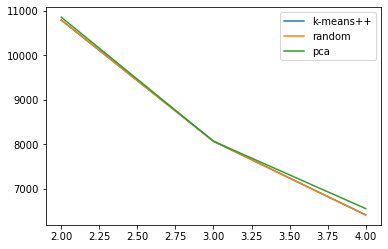

In [13]:
pd.DataFrame(dists_dict).set_index(pd.Index(range(2,5))).plot()

k-means++


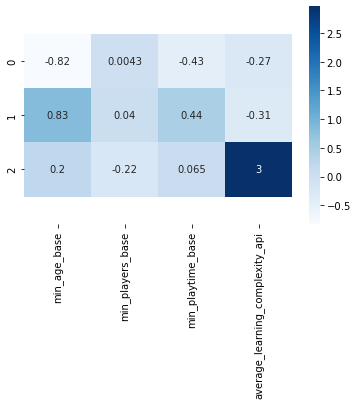

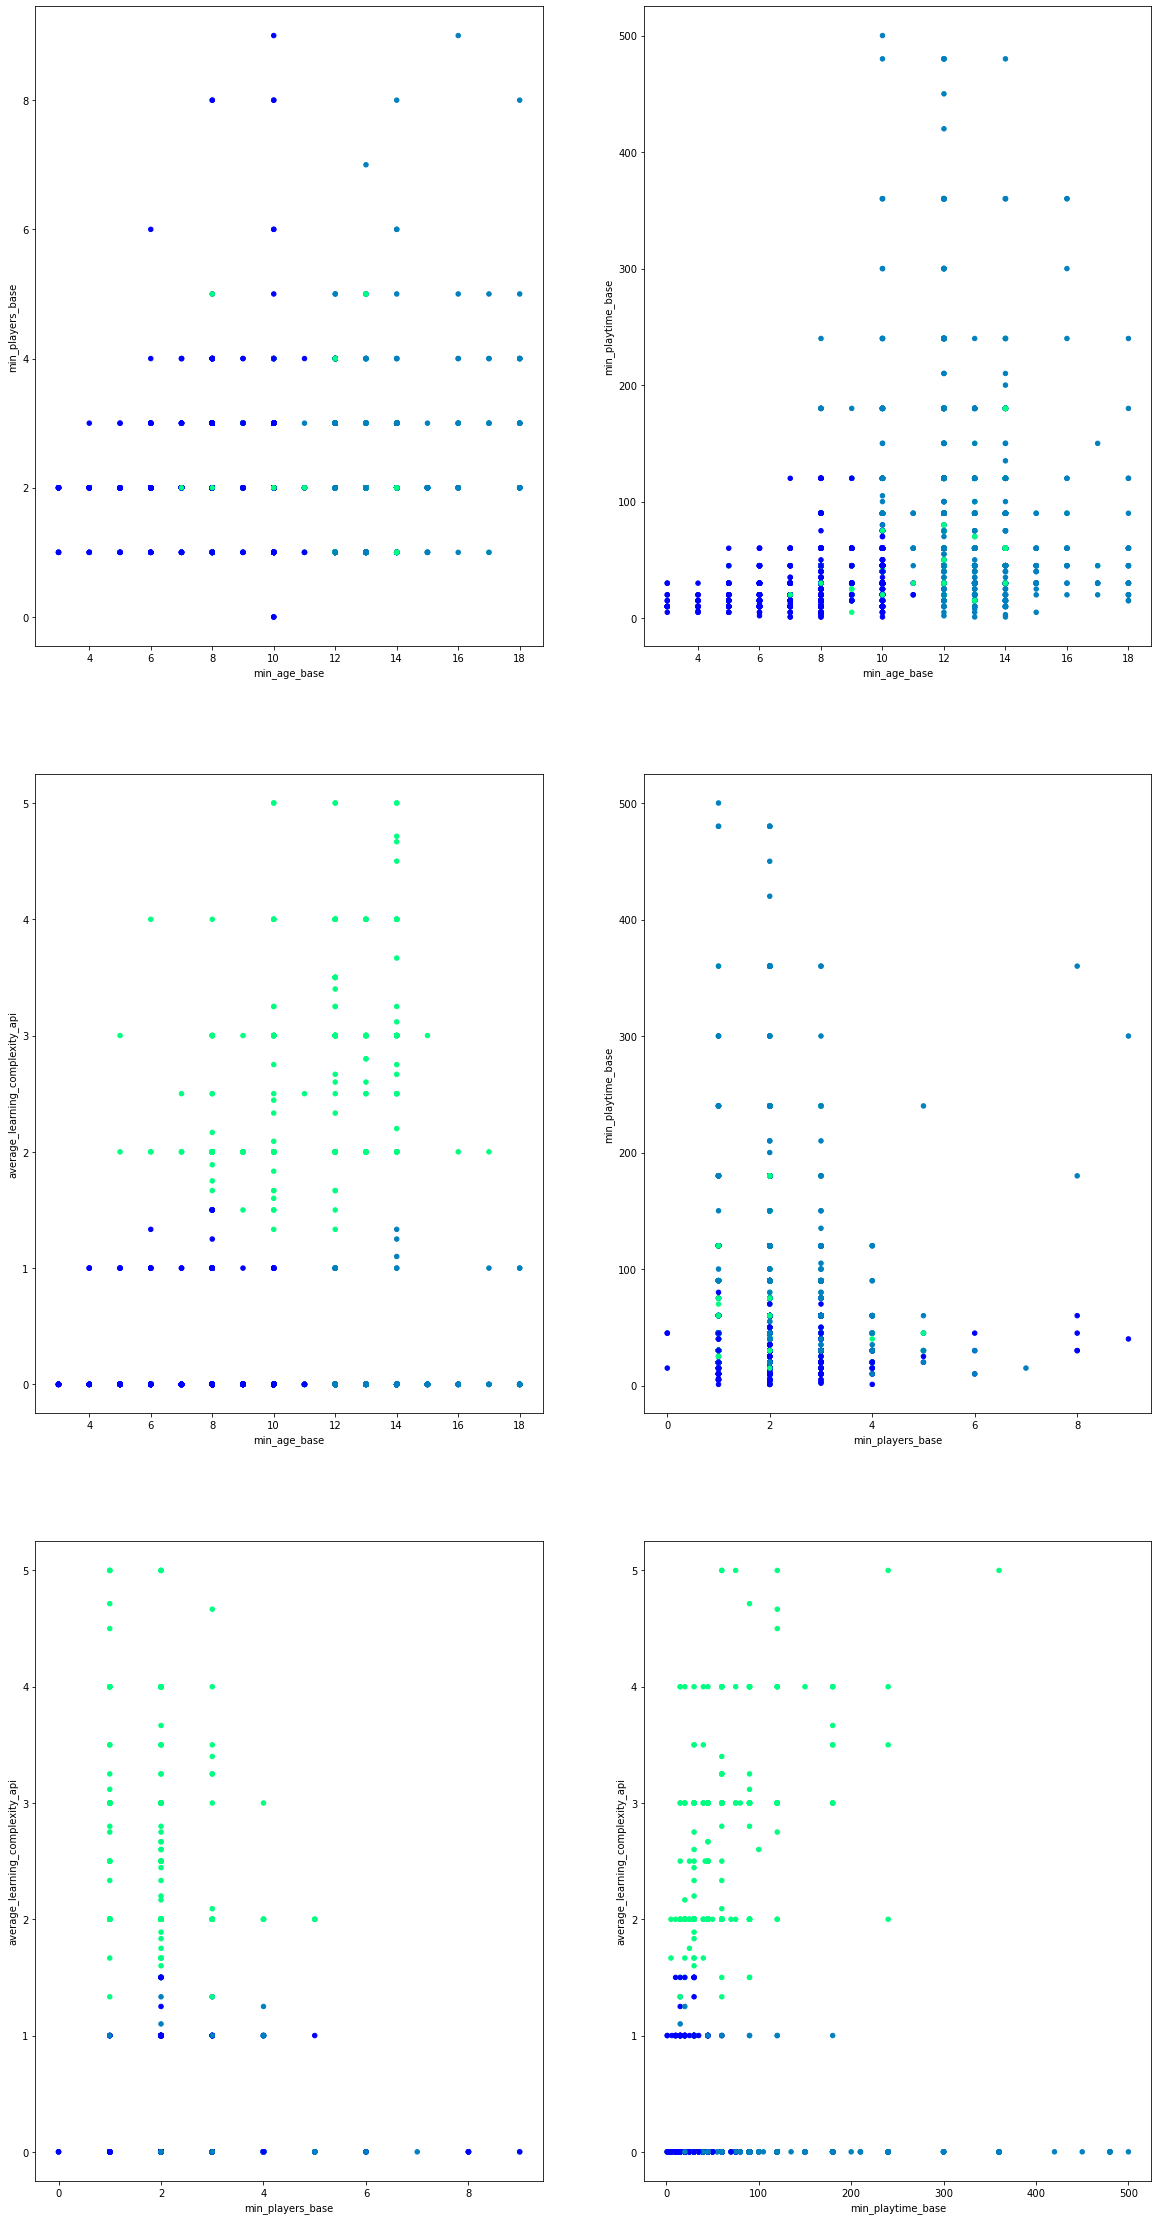

random


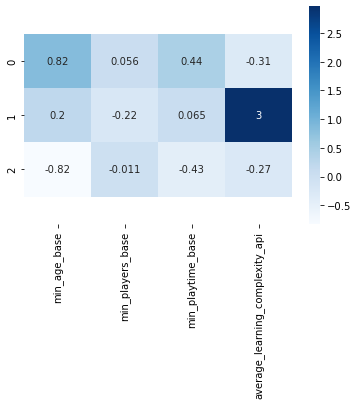

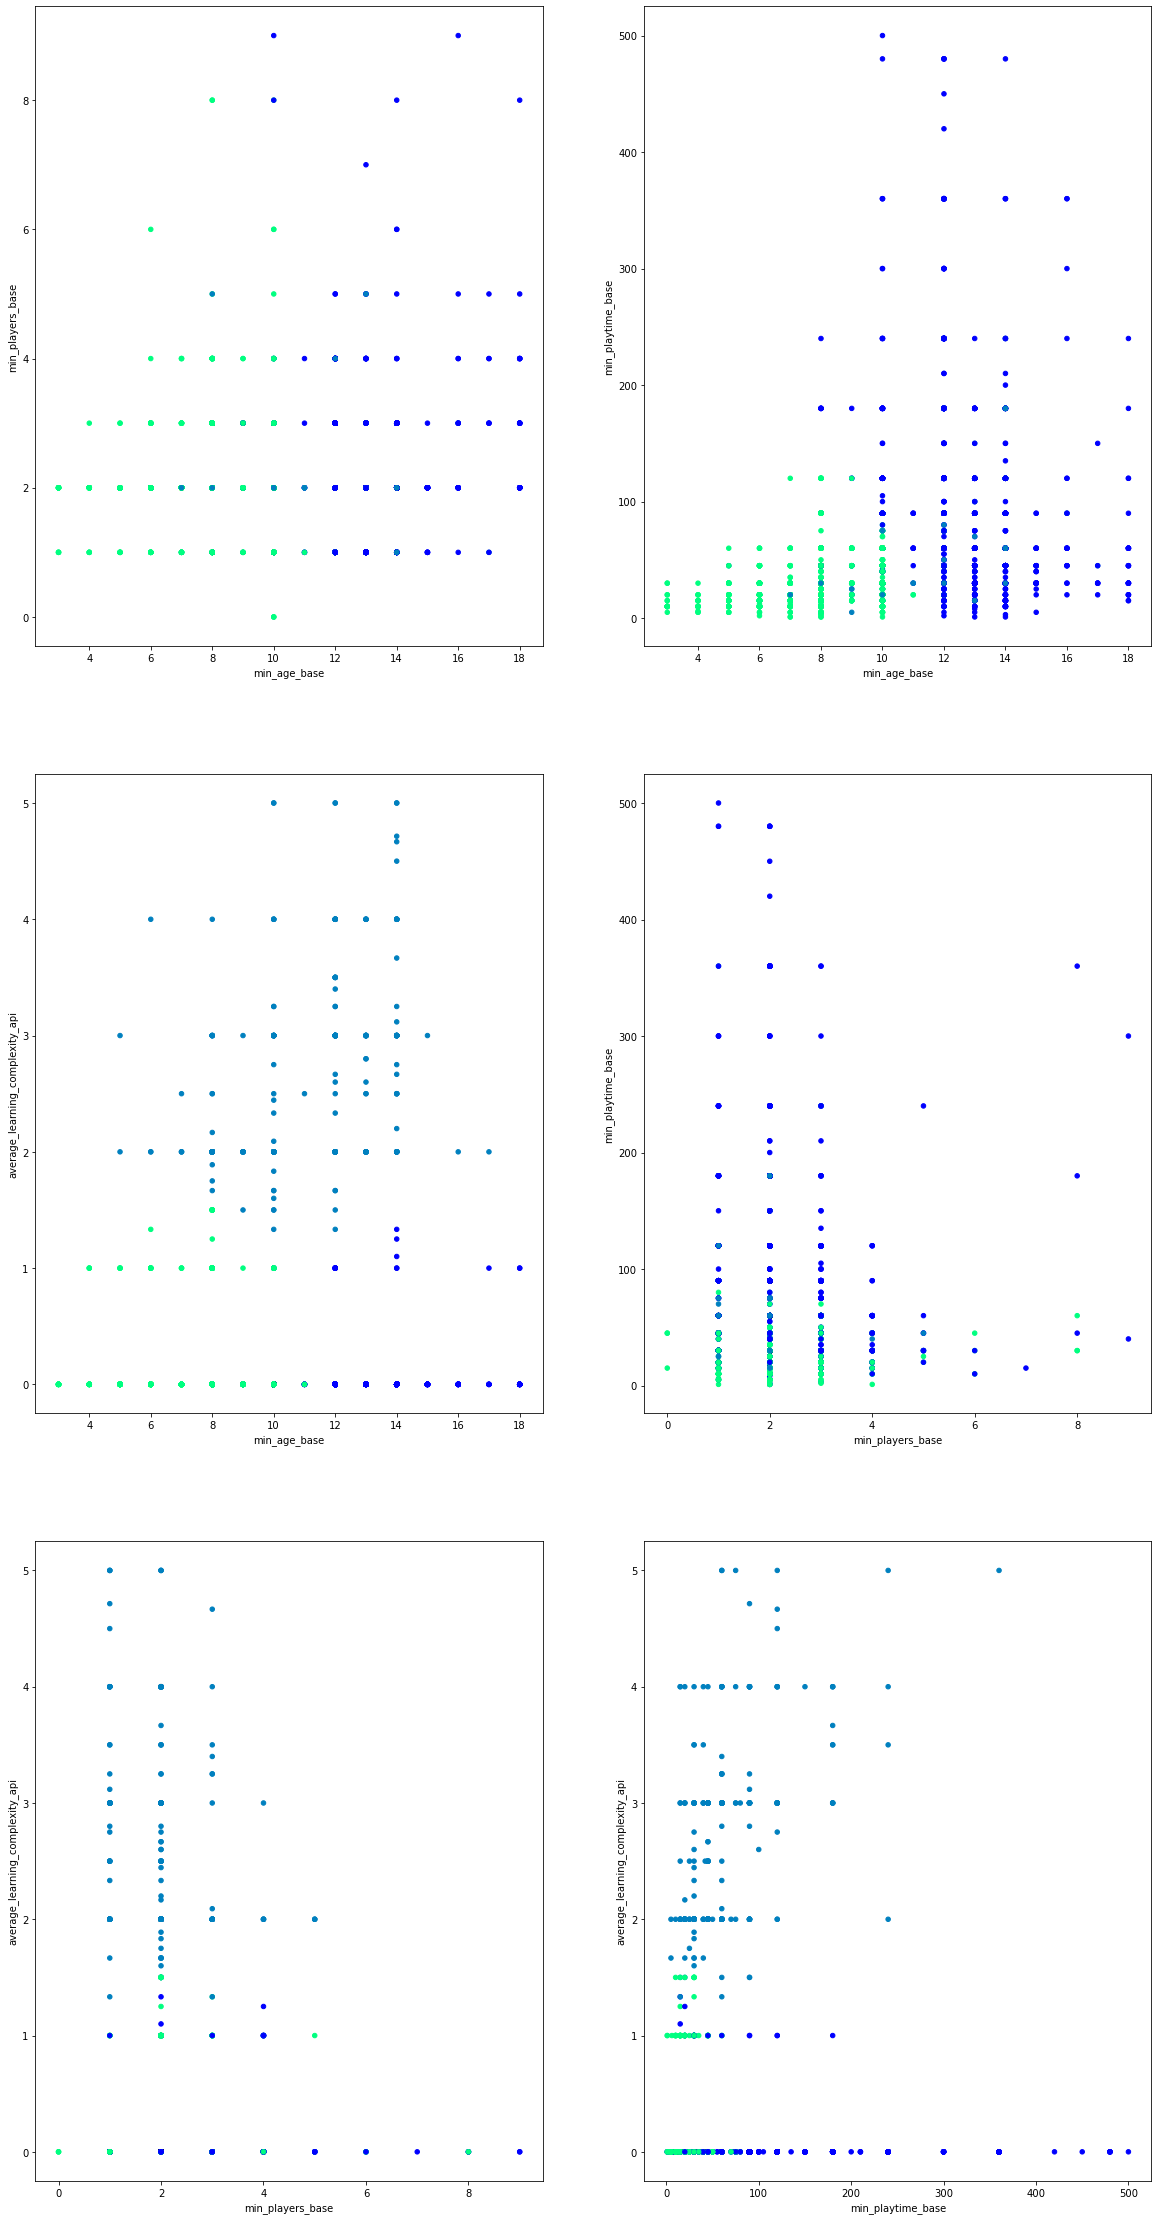

pca


C:\Users\abogn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


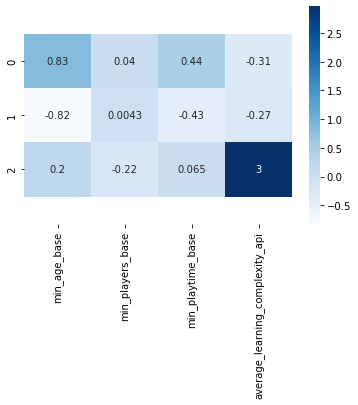

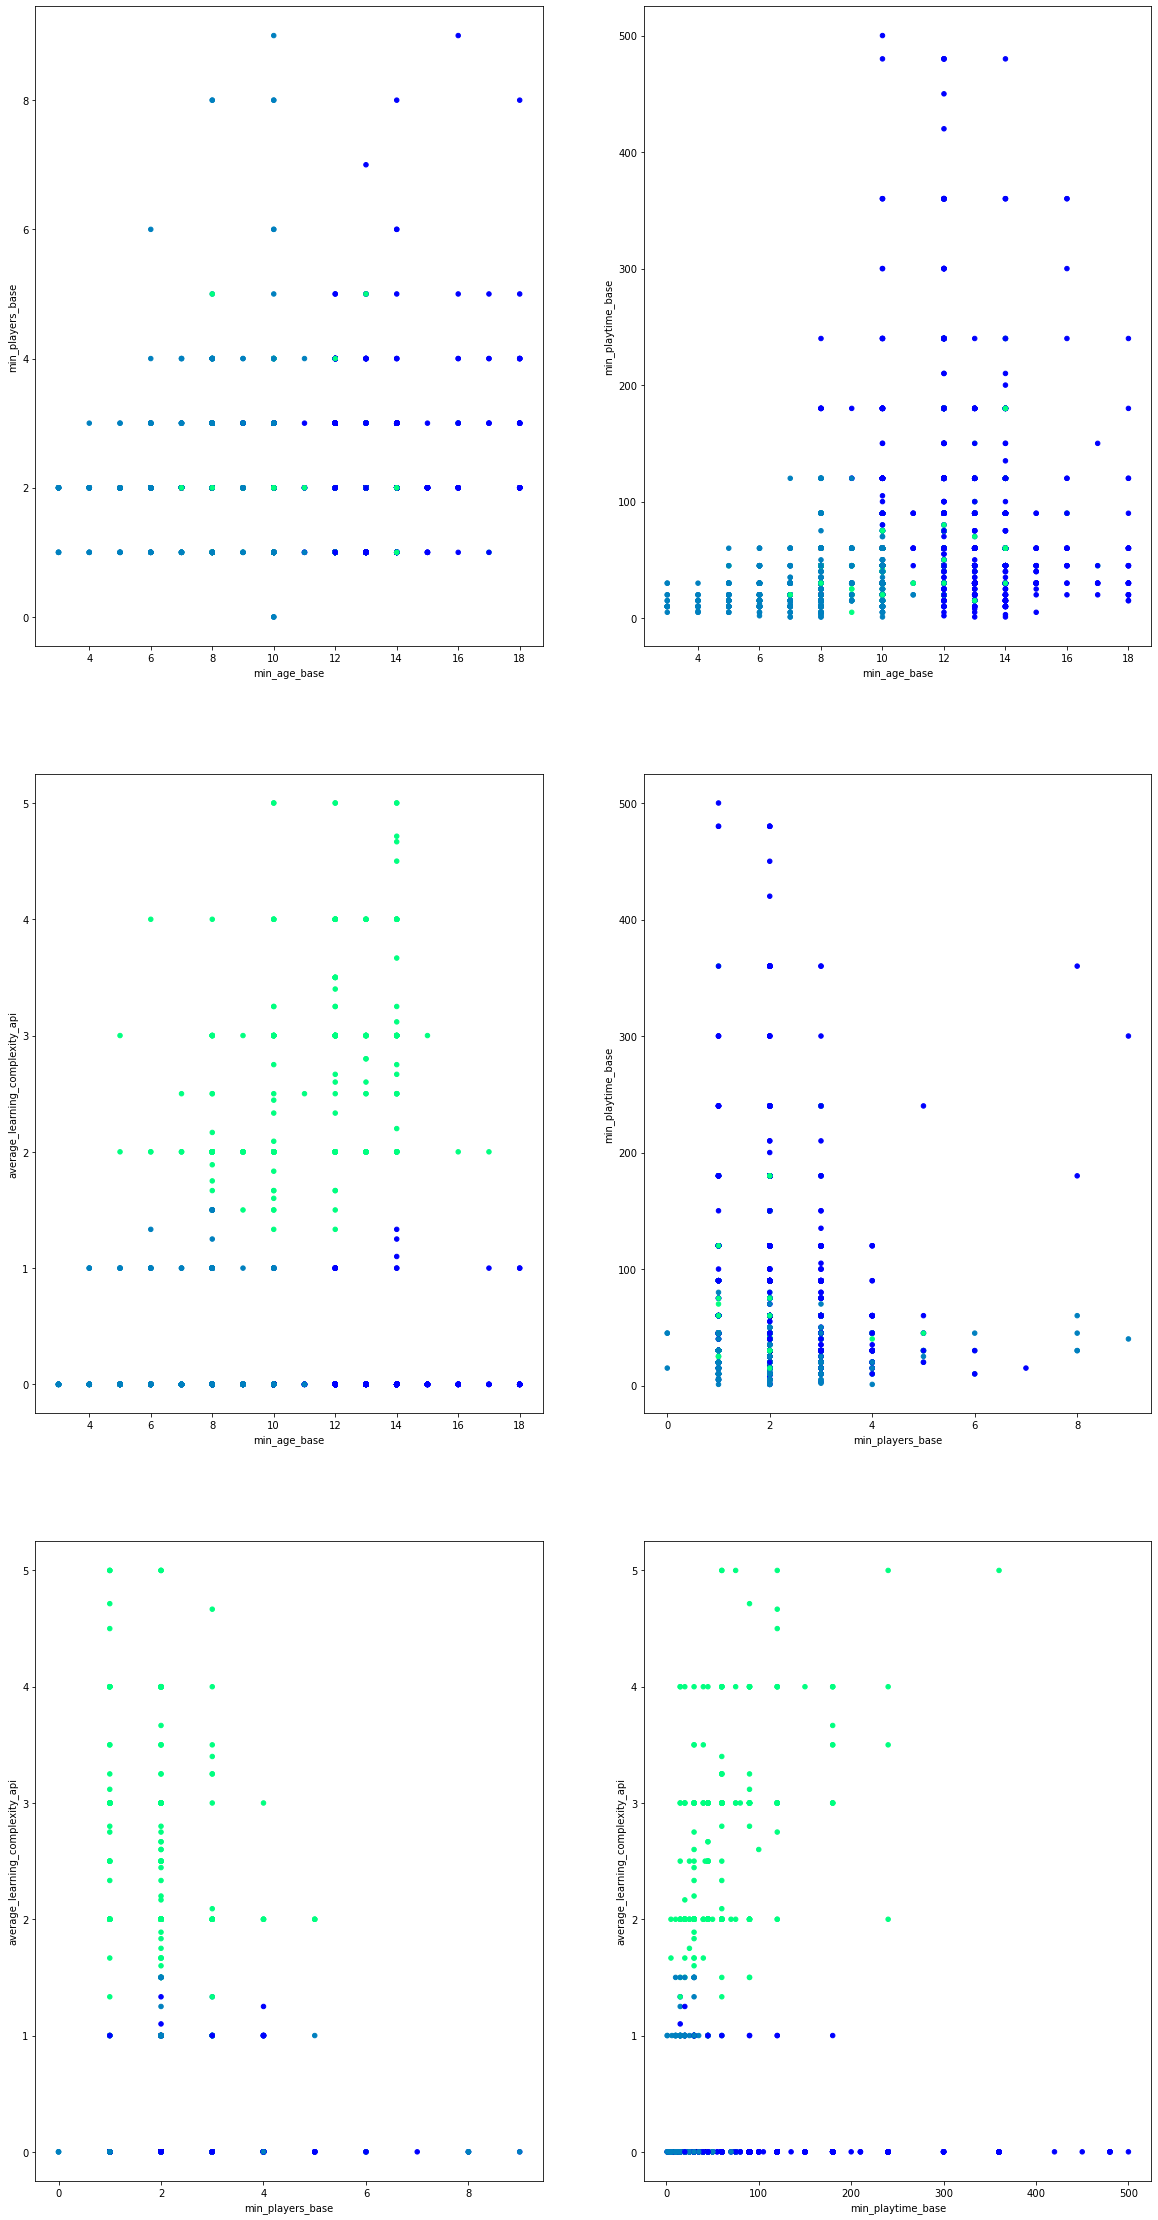

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
%matplotlib inline

def draw_cluster_plot(df, estimator, figsize=(20,40), cmap_name='summer'):
    cmap = matplotlib.cm.get_cmap('winter')
    xy_toplot = list(combinations(df.columns,2))
    fig, axes = plt.subplots(nrows=len(xy_toplot)//2,ncols=2, figsize=figsize)
    i = 0
    for x_ax, y_ax in xy_toplot:
        df.plot.scatter(x=x_ax, y=y_ax, c=estimator.labels_, cmap=cmap, ax=axes[i//2, i%2],colorbar=False)
        i += 1
    plt.show()

for init_method in ['k-means++','random','pca']:
    print(init_method)
    estimator = fit_kmeans(data, 3, init_method)
    centers = pd.DataFrame(estimator.cluster_centers_)
    centers.columns = df.columns
    ax = sns.heatmap(centers, annot=True, cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    draw_cluster_plot(df, estimator)

### Clusters:
* Possible interpretation: 
    * cluster 0 short games, avaliable to everyone -- family, party games
    * cluster 1 longer, adult games to be played in groups -- casual adult games
    * cluster 2 difficult played in small groups -- hardcore games


In [15]:
# TODO: decide about the init method and choose cluster number, interpret the clusters

In [16]:
# Eg. let's say we chose k-means with 4 clusters

# Fit method
kmeans = fit_kmeans(df, 3, 'k-means++')

# Save cluster membership

board_games['cluster_membership'] = kmeans.labels_
len(kmeans.labels_) # cluster membership

3457

<AxesSubplot:xlabel='cluster_membership', ylabel='price_api'>

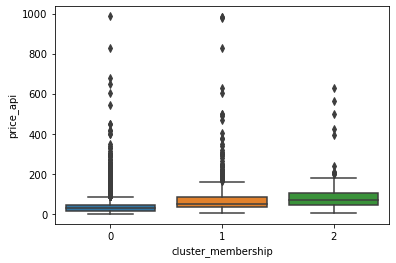

In [17]:
# Distribution of price by clusters
sns.boxplot(data=board_games, x='cluster_membership', y='price_api')

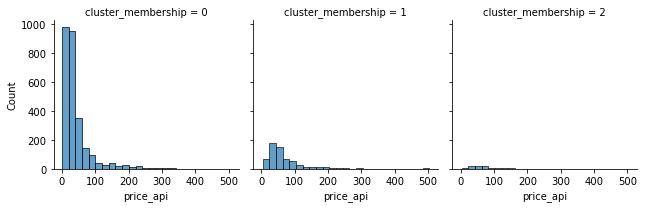

In [18]:
g = sns.FacetGrid(board_games[board_games["price_api"]<500], col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='count', binwidth = 20)
g.add_legend()

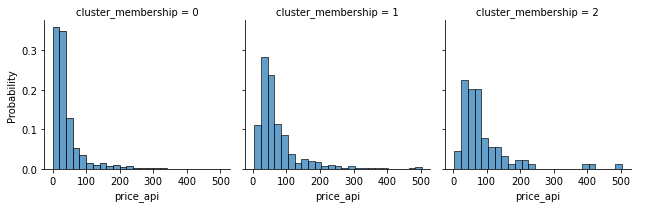

In [19]:
g = sns.FacetGrid(board_games[board_games["price_api"]<500], col="cluster_membership")
g.map(sns.histplot, "price_api", alpha=.7, stat='probability', binwidth = 20)
g.add_legend()

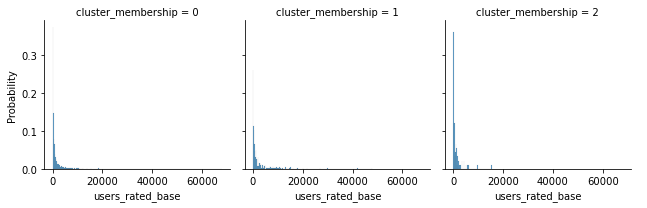

In [20]:
g = sns.FacetGrid(board_games, col="cluster_membership")
g.map(sns.histplot, "users_rated_base", alpha=.7, stat='probability', binwidth = 200)
g.add_legend()

In [21]:
# Most frequent categories in each group
dummies = board_games[board_games.columns[pd.Series(board_games.columns).str.endswith('_d')]]
dummies = dummies.loc[:, ~dummies.columns.isin(['game_id_base_d'])]


dummies["cluster_membership"] = board_games["cluster_membership"]
dummies_grouped = dummies.groupby(['cluster_membership']).sum()
dummies_grouped

,economic_d,negotiation_d,political_d,cardgame_d,fantasy_d,abstractstrategy_d,medieval_d,ancient_d,exploration_d,travel_d,farming_d,mythology_d,bluffing_d,sciencefiction_d,collectiblecomponents_d,dice_d,fighting_d,print&play_d,miniatures_d,racing_d,americanwest_d,citybuilding_d,adventure_d,wargame_d,civilization_d,renaissance_d,humor_d,electronic_d,horror_d,novel-based_d,territorybuilding_d,maze_d,puzzle_d,real-time_d,partygame_d,aviation/flight_d,worldwarii_d,americancivilwar_d,ageofreason_d,worldwari_d,animals_d,childrensgame_d,nautical_d,pirates_d,murder/mystery_d,transportation_d,prehistoric_d,deduction_d,trains_d,industry/manufacturing_d,action/dexterity_d,sports_d,gamesystem_d,wordgame_d,spies/secretagents_d,educational_d,medical_d,mafia_d,zombies_d,comicbook/strip_d,civilwar_d,spaceexploration_d,americanindianwars_d,americanrevolutionarywar_d,napoleonic_d,post-napoleonic_d,book_d,movies/tv/radiotheme_d,arabian_d,memory_d,modernwarfare_d,environmental_d,number_d,religious_d,music_d,trivia_d,pikeandshot_d,videogametheme_d,math_d,vietnamwar_d,mature/adult_d,koreanwar_d,expansionforbase-game_d
cluster_membership,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,174.0,80.0,53.0,1037.0,412.0,223.0,162.0,105.0,102.0,32.0,41.0,65.0,237.0,222.0,41.0,284.0,237.0,48.0,95.0,93.0,33.0,108.0,135.0,125.0,53.0,46.0,207.0,38.0,111.0,79.0,90.0,31.0,74.0,140.0,307.0,29.0,47.0,7.0,5.0,10.0,201.0,199.0,71.0,56.0,60.0,46.0,28.0,217.0,43.0,44.0,129.0,43.0,3.0,77.0,48.0,55.0,13.0,21.0,51.0,46.0,1.0,43.0,1.0,2.0,3.0,5.0,3.0,137.0,16.0,64.0,12.0,27.0,25.0,19.0,11.0,65.0,0.0,42.0,6.0,1.0,15.0,0.0,3.0
1,172.0,66.0,46.0,56.0,107.0,7.0,56.0,38.0,61.0,6.0,11.0,13.0,27.0,92.0,4.0,27.0,102.0,4.0,45.0,9.0,12.0,51.0,74.0,117.0,51.0,34.0,28.0,3.0,29.0,30.0,54.0,1.0,2.0,4.0,17.0,9.0,32.0,5.0,8.0,2.0,7.0,8.0,30.0,7.0,13.0,45.0,8.0,12.0,29.0,30.0,2.0,8.0,0.0,1.0,7.0,8.0,2.0,4.0,12.0,8.0,7.0,24.0,3.0,3.0,6.0,3.0,2.0,34.0,7.0,1.0,12.0,7.0,3.0,7.0,2.0,13.0,0.0,18.0,3.0,3.0,2.0,1.0,1.0
2,17.0,9.0,10.0,2.0,2.0,0.0,3.0,10.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,2.0,2.0,74.0,6.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,26.0,3.0,6.0,5.0,0.0,0.0,6.0,0.0,2.0,6.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,2.0,0.0


In [22]:
# Transpose
dummies_grouped_t = dummies_grouped.T 

In [23]:
type(dummies_grouped_t)
# dummies_grouped_t.columns

pandas.core.frame.DataFrame

In [24]:
dummies_grouped_t[0].sort_values(ascending=False).head(20)

cardgame_d                1037.0
fantasy_d                  412.0
partygame_d                307.0
dice_d                     284.0
bluffing_d                 237.0
fighting_d                 237.0
abstractstrategy_d         223.0
sciencefiction_d           222.0
deduction_d                217.0
humor_d                    207.0
animals_d                  201.0
childrensgame_d            199.0
economic_d                 174.0
medieval_d                 162.0
real-time_d                140.0
movies/tv/radiotheme_d     137.0
adventure_d                135.0
action/dexterity_d         129.0
wargame_d                  125.0
horror_d                   111.0
Name: 0, dtype: float64

In [25]:
dummies_grouped_t[1].sort_values(ascending=False).head(20)

economic_d                172.0
wargame_d                 117.0
fantasy_d                 107.0
fighting_d                102.0
sciencefiction_d           92.0
adventure_d                74.0
negotiation_d              66.0
exploration_d              61.0
medieval_d                 56.0
cardgame_d                 56.0
territorybuilding_d        54.0
civilization_d             51.0
citybuilding_d             51.0
political_d                46.0
miniatures_d               45.0
transportation_d           45.0
ancient_d                  38.0
renaissance_d              34.0
movies/tv/radiotheme_d     34.0
worldwarii_d               32.0
Name: 1, dtype: float64

In [26]:
dummies_grouped_t[2].sort_values(ascending=False).head(20)

wargame_d             74.0
worldwarii_d          26.0
economic_d            17.0
political_d           10.0
ancient_d             10.0
negotiation_d          9.0
trains_d               9.0
modernwarfare_d        7.0
nautical_d             6.0
ageofreason_d          6.0
civilization_d         6.0
sciencefiction_d       6.0
transportation_d       6.0
worldwari_d            5.0
fighting_d             3.0
americancivilwar_d     3.0
medieval_d             3.0
napoleonic_d           3.0
renaissance_d          3.0
murder/mystery_d       2.0
Name: 2, dtype: float64

In [27]:
# Price variables
price = board_games.loc[:, board_games.columns.isin([
    'price_api',
    'price_au_api',
    'price_ca_api',
    'price_uk_api'
    ])]
price.head()

,price_api,price_ca_api,price_uk_api,price_au_api
1,69.99,0.00,0.0,0.00
4,79.99,40.49,0.0,49.99
5,49.99,0.00,0.0,0.00
6,29.95,23.78,0.0,0.00
7,166.47,207.84,0.0,0.00


In [28]:
# Check nulls
price.isnull().sum()

price_api       0
price_ca_api    0
price_uk_api    0
price_au_api    0
dtype: int64

In [29]:
price.agg(
    {
        "price_api": ["min", "max", "mean", "median", "std"],
        "price_au_api": ["min", "max", "mean", "median", "std"],
        "price_ca_api": ["min", "max", "mean", "median", "std"],        
        "price_uk_api": ["min", "max", "mean", "median", "std"]          
    }
)

,price_api,price_au_api,price_ca_api,price_uk_api
min,0.200000,0.000000,0.000000,0.000000
max,985.880000,264.950000,848.910000,228.790000
mean,51.943457,18.401119,23.449138,5.316673
median,31.990000,0.000000,14.350000,0.000000
std,71.681806,32.307111,37.061122,13.824317


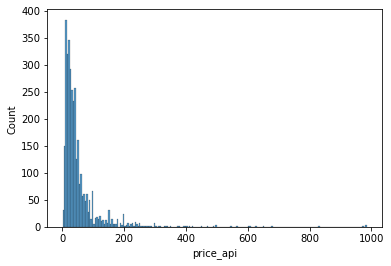

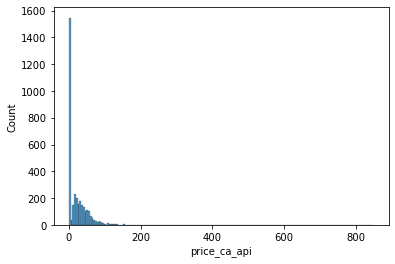

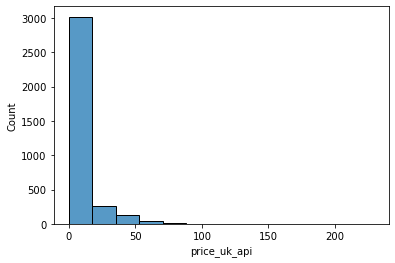

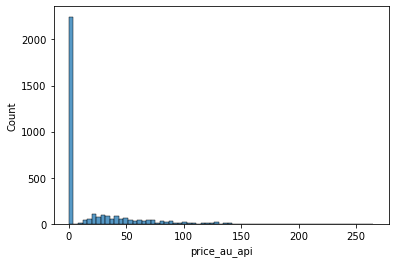

In [30]:
# Check histograms
price_list = price.columns.values.tolist()
price_list

for x in price_list: 
    sns.histplot(price[x])
    plt.show()

In [31]:
# Zeros
print(len(price[price['price_api']==0])/len(price),
len(price[price['price_au_api']==0])/len(price),
len(price[price['price_ca_api']==0])/len(price),
len(price[price['price_uk_api']==0])/len(price))

0.0 0.6494070002892681 0.44605148973098063 0.8116864333236911


In [32]:
# p
price['price_api_cat'] = pd.cut(x=price['price_api'], 
                     bins=[0, 1, 100000000000000000000],
                     labels=['0', 
                             '1'])

C:\Users\abogn\AppData\Local\Temp/ipykernel_2732/1159827161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['price_api_cat'] = pd.cut(x=price['price_api'],


In [33]:
agg = price.groupby('price_api_cat').agg({'price_api':'min'}).rename(columns={'price_api':'mean'})
agg

,mean
price_api_cat,
0,0.20
1,1.75


In [34]:
price['price_api_cat'] = np.where(price['price_api'] == 0, 0, 1)

price

C:\Users\abogn\AppData\Local\Temp/ipykernel_2732/4183189832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['price_api_cat'] = np.where(price['price_api'] == 0, 0, 1)


,price_api,price_ca_api,price_uk_api,price_au_api,price_api_cat
1,69.99,0.00,0.00,0.00,1
4,79.99,40.49,0.00,49.99,1
5,49.99,0.00,0.00,0.00,1
6,29.95,23.78,0.00,0.00,1
7,166.47,207.84,0.00,0.00,1
...,...,...,...,...,...
5545,30.49,39.95,35.99,60.00,1
5548,100.00,0.00,0.00,0.00,1
5549,52.02,64.95,36.57,0.00,1
5550,81.20,0.00,0.00,69.95,1
